C:\Users\NoxiePC\AppData\Local\Temp\ipykernel_9708\681325361.py:24: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  'date': pd.date_range('2023-01-01', periods=n_rows, freq='S'),


Guardando dataset en Parquet y CSV...

=== Tiempos para Parquet ===
Carga (Parquet): 0.0648 segundos
Filtrado (Parquet): 0.0141 segundos
Agrupación (Parquet): 0.0305 segundos
Unión (Parquet): 0.1190 segundos
Estadísticas (Parquet): 0.0323 segundos

=== Tiempos para CSV ===
Carga (CSV): 0.6199 segundos
Filtrado (CSV): 0.0166 segundos
Agrupación (CSV): 0.0330 segundos
Unión (CSV): 0.1397 segundos
Estadísticas (CSV): 0.0350 segundos


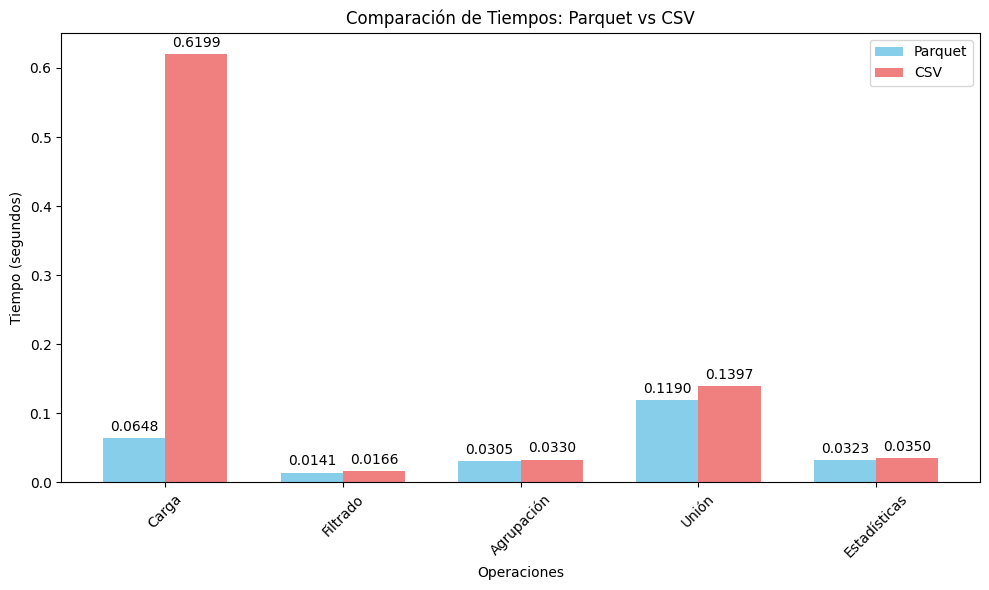


Archivos temporales eliminados.


In [5]:
import pandas as pd
import numpy as np
import time
import os
import matplotlib.pyplot as plt

# Función para medir el tiempo de una operación
def measure_time(operation_name, func, times_dict, format_name):
    start_time = time.time()
    result = func()
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"{operation_name} ({format_name}): {elapsed_time:.4f} segundos")
    times_dict[operation_name][format_name] = elapsed_time
    return result

# 1. Generar un dataset sintético (1M filas, 5 columnas)
np.random.seed(42)
n_rows = 1_000_000
data = {
    'id': np.arange(n_rows),
    'value': np.random.randn(n_rows),
    'category': np.random.choice(['A', 'B', 'C'], n_rows),
    'date': pd.date_range('2023-01-01', periods=n_rows, freq='S'),
    'flag': np.random.randint(0, 2, n_rows)
}
df = pd.DataFrame(data)

# 2. Guardar el dataset en Parquet y CSV
print("Guardando dataset en Parquet y CSV...")
df.to_parquet('dataset.parquet', engine='pyarrow', compression='snappy')
df.to_csv('dataset.csv', index=False)

# 3. Definir operaciones comunes de Pandas
def load_parquet():
    return pd.read_parquet('dataset.parquet')

def load_csv():
    return pd.read_csv('dataset.csv')

def filter_data(df):
    return df[df['value'] > 0]

def groupby_data(df):
    return df.groupby('category')['value'].mean()

def merge_data(df):
    df_subset = df[['id', 'flag']].sample(frac=0.1, random_state=42)
    return df.merge(df_subset, on='id', how='left')

def stats_data(df):
    return df['value'].describe()

# 4. Diccionario para almacenar tiempos
times = {
    'Carga': {'Parquet': 0, 'CSV': 0},
    'Filtrado': {'Parquet': 0, 'CSV': 0},
    'Agrupación': {'Parquet': 0, 'CSV': 0},
    'Unión': {'Parquet': 0, 'CSV': 0},
    'Estadísticas': {'Parquet': 0, 'CSV': 0}
}

# 5. Comparar tiempos de carga y procesamiento
print("\n=== Tiempos para Parquet ===")
# Cargar desde Parquet
df_parquet = measure_time("Carga", load_parquet, times, "Parquet")

# Operaciones
measure_time("Filtrado", lambda: filter_data(df_parquet), times, "Parquet")
measure_time("Agrupación", lambda: groupby_data(df_parquet), times, "Parquet")
measure_time("Unión", lambda: merge_data(df_parquet), times, "Parquet")
measure_time("Estadísticas", lambda: stats_data(df_parquet), times, "Parquet")

print("\n=== Tiempos para CSV ===")
# Cargar desde CSV
df_csv = measure_time("Carga", load_csv, times, "CSV")

# Operaciones
measure_time("Filtrado", lambda: filter_data(df_csv), times, "CSV")
measure_time("Agrupación", lambda: groupby_data(df_csv), times, "CSV")
measure_time("Unión", lambda: merge_data(df_csv), times, "CSV")
measure_time("Estadísticas", lambda: stats_data(df_csv), times, "CSV")

# 6. Generar gráfica de barras
operations = list(times.keys())
parquet_times = [times[op]['Parquet'] for op in operations]
csv_times = [times[op]['CSV'] for op in operations]

x = np.arange(len(operations))  # Posiciones de las barras
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, parquet_times, width, label='Parquet', color='skyblue')
bars2 = ax.bar(x + width/2, csv_times, width, label='CSV', color='lightcoral')

# Personalizar la gráfica
ax.set_xlabel('Operaciones')
ax.set_ylabel('Tiempo (segundos)')
ax.set_title('Comparación de Tiempos: Parquet vs CSV')
ax.set_xticks(x)
ax.set_xticklabels(operations, rotation=45)
ax.legend()

# Añadir valores encima de las barras
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento vertical
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()

# 7. Limpiar archivos generados
os.remove('dataset.parquet')
os.remove('dataset.csv')
print("\nArchivos temporales eliminados.")